In [22]:
import os
import torch
import matplotlib.pyplot as plt
import pickle
from data_loader.data_loader import TrainDataProvider

/opt/homebrew/Caskroom/miniconda/base/envs/openmmlab/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


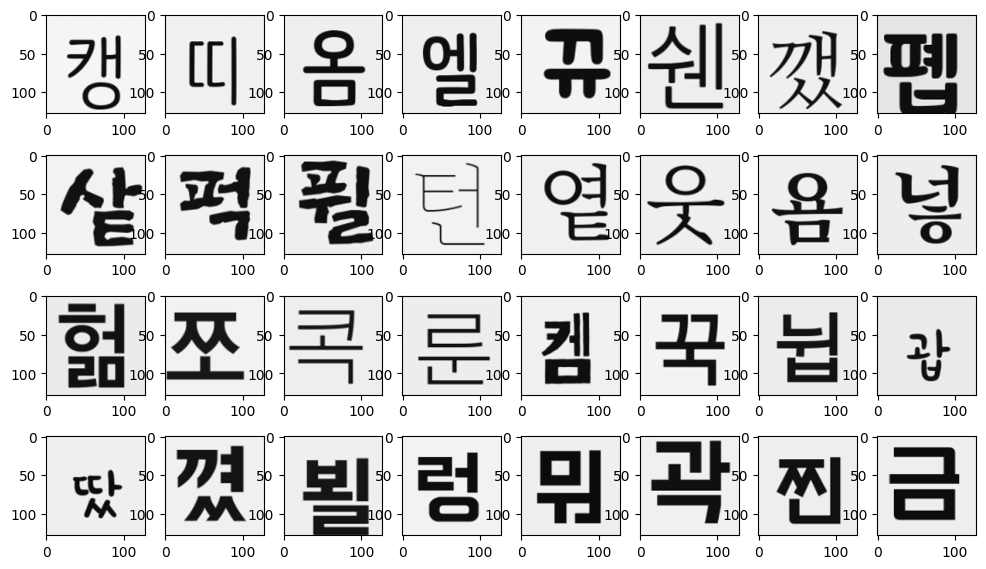

In [74]:
fixed_dir = "./data/"
fixed_source_1 = torch.load(os.path.join(fixed_dir, 'fixed_source.pkl'), map_location='cpu')
fixed_target_1 = torch.load(os.path.join(fixed_dir, 'fixed_target.pkl'), map_location='cpu')

plt.figure(figsize=(12, 7))
for idx, image in enumerate(fixed_target_1):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().numpy(), cmap='gray')
plt.show()

unpickled total 47017 examples
train examples -> 47017
1.0
original cropped image size: (90, 77)
final image size: (128, 128)


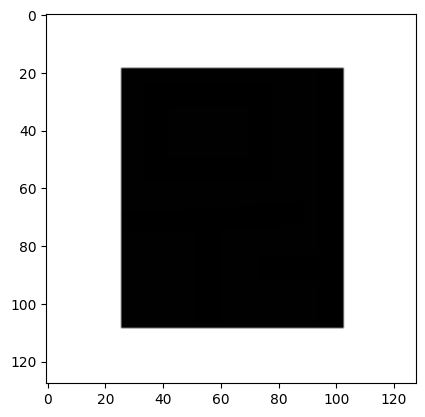

In [73]:
# -*- coding: utf-8 -*-
from __future__ import print_function
from __future__ import absolute_import
import pickle as pickle
import numpy as np
import random
import os
import torch
import sys


sys.path.append("./")
from utils import *


def get_batch_iter(examples, batch_size, augment, with_charid=False):
    # the transpose ops requires deterministic
    # batch size, thus comes the padding
    padded = pad_seq(examples, batch_size)

    def process(img):
        img = bytes_to_file(img)
        try:
            img_A, img_B = read_split_image(img)
            if augment:
                # augment the image by:
                # 1) enlarge the image
                # 2) random crop the image back to its original size
                # NOTE: image A and B needs to be in sync as how much
                # to be shifted
                w, h = img_A.shape
                multiplier = random.uniform(1.00, 1.20)
                # add an eps to prevent cropping issue
                nw = int(multiplier * w) + 1
                nh = int(multiplier * h) + 1
                shift_x = int(np.ceil(np.random.uniform(0.01, nw - w)))
                shift_y = int(np.ceil(np.random.uniform(0.01, nh - h)))
                img_A = shift_and_resize_image(img_A, shift_x, shift_y, nw, nh)
                img_B = shift_and_resize_image(img_B, shift_x, shift_y, nw, nh)
            img_A = normalize_image(img_A)
            img_A = img_A.reshape(1, len(img_A), len(img_A[0]))
            img_B = normalize_image(img_B)
            img_B = img_B.reshape(1, len(img_B), len(img_B[0]))
            return np.concatenate([img_A, img_B], axis=0)
        finally:
            img.close()

    def batch_iter(with_charid=with_charid):
        for i in range(0, len(padded), batch_size):
            batch = padded[i : i + batch_size]
            labels = [e[0] for e in batch]
            if with_charid:
                charid = [e[1] for e in batch]
                image = [process(e[2]) for e in batch]
                image = np.array(image).astype(np.float32)
                image = torch.from_numpy(image)
                # stack into tensor
                yield [labels, charid, image]
            else:
                image = [process(e[1]) for e in batch]
                image = np.array(image).astype(np.float32)
                image = torch.from_numpy(image)
                # stack into tensor
                yield [labels, image]

    return batch_iter(with_charid=with_charid)


class PickledImageProvider(object):
    def __init__(self, obj_path, verbose):
        self.obj_path = obj_path
        self.verbose = verbose
        self.examples = self.load_pickled_examples()

    def load_pickled_examples(self):
        with open(self.obj_path, "rb") as of:
            examples = list()
            while True:
                try:
                    e = pickle.load(of)
                    examples.append(e)
                except EOFError:
                    break
                except Exception:
                    pass
            if self.verbose:
                print("unpickled total %d examples" % len(examples))
            return examples


class TrainDataProvider(object):
    def __init__(
        self,
        data_dir,
        train_name="train.obj",
        val_name="val.obj",
        filter_by_font=None,
        filter_by_charid=None,
        verbose=True,
        val=True,
    ):
        self.data_dir = data_dir
        self.filter_by_font = filter_by_font
        self.filter_by_charid = filter_by_charid
        self.train_path = os.path.join(self.data_dir, train_name)
        self.val_path = os.path.join(self.data_dir, val_name)
        self.train = PickledImageProvider(self.train_path, verbose)
        if val:
            self.val = PickledImageProvider(self.val_path, verbose)
        if self.filter_by_font:
            if verbose:
                print("filter by label ->", filter_by_font)
            self.train.examples = [
                e for e in self.train.examples if e[0] in self.filter_by_font
            ]
            if val:
                self.val.examples = [
                    e for e in self.val.examples if e[0] in self.filter_by_font
                ]
        if self.filter_by_charid:
            if verbose:
                print("filter by char ->", filter_by_charid)
            self.train.examples = [
                e for e in self.train.examples if e[1] in filter_by_charid
            ]
            if val:
                self.val.examples = [
                    e for e in self.val.examples if e[1] in filter_by_charid
                ]
        if verbose:
            if val:
                print(
                    "train examples -> %d, val examples -> %d"
                    % (len(self.train.examples), len(self.val.examples))
                )
            else:
                print("train examples -> %d" % (len(self.train.examples)))

    def get_train_iter(self, batch_size, shuffle=True, with_charid=False):
        training_examples = self.train.examples[:]
        if shuffle:
            np.random.shuffle(training_examples)

        if with_charid:
            return get_batch_iter(
                training_examples, batch_size, augment=True, with_charid=True
            )
        else:
            return get_batch_iter(training_examples, batch_size, augment=True)

    def get_val_iter(self, batch_size, shuffle=True, with_charid=False):
        """
        Validation iterator runs forever
        """
        val_examples = self.val.examples[:]
        if shuffle:
            np.random.shuffle(val_examples)
        if with_charid:
            return get_batch_iter(
                val_examples, batch_size, augment=True, with_charid=True
            )
        else:
            return get_batch_iter(val_examples, batch_size, augment=True)

    def compute_total_batch_num(self, batch_size):
        """Total padded batch num"""
        return int(np.ceil(len(self.train.examples) / float(batch_size)))

    def get_all_labels(self):
        """Get all training labels"""
        return list({e[0] for e in self.train.examples})

    def get_train_val_path(self):
        return self.train_path, self.val_path


def save_fixed_sample(
    sample_size,
    img_size,
    data_dir,
    save_dir,
    val=False,
    verbose=True,
    with_charid=True,
    resize_fix=90,
):
    data_provider = TrainDataProvider(data_dir, verbose=verbose, val=val)
    if not val:
        train_batch_iter = data_provider.get_train_iter(
            sample_size, with_charid=with_charid
        )
    else:
        train_batch_iter = data_provider.get_val_iter(
            sample_size, with_charid=with_charid
        )

    for batch in train_batch_iter:
        if with_charid:
            font_ids, _, batch_images = batch
        else:
            font_ids, batch_images = batch
        fixed_batch = batch_images.cpu()
        fixed_source = fixed_batch[:, 1, :, :].reshape(
            sample_size, 1, img_size, img_size
        )
        fixed_target = fixed_batch[:, 0, :, :].reshape(
            sample_size, 1, img_size, img_size
        )

        # centering
        for idx, (image_S, image_T) in enumerate(zip(fixed_source, fixed_target)):
            image_S = image_S.cpu().detach().numpy().reshape(img_size, img_size)
            image_S = np.array(list(map(round_function, image_S.flatten()))).reshape(
                128, 128
            )
            print(image_S[0][0])
            plt.imshow(add_padding(
        tight_crop_image(image_S, resize_fix=90), image_size=128, verbose=verbose, pad_value=1
    ), cmap='gray')
            
            break
            image_S = centering_image(image_S, resize_fix=90)
            
            
            fixed_source[idx] = torch.tensor(image_S).view([1, img_size, img_size])
            image_T = image_T.cpu().detach().numpy().reshape(img_size, img_size)
            image_T = np.array(list(map(round_function, image_T.flatten()))).reshape(
                128, 128
            )
            image_T = centering_image(image_T, resize_fix=resize_fix)
            fixed_target[idx] = torch.tensor(image_T).view([1, img_size, img_size])

        fixed_label = np.array(font_ids)
        source_with_label = [
            (label, image_S.cpu().detach().numpy())
            for label, image_S in zip(fixed_label, fixed_source)
        ]
        source_with_label = sorted(source_with_label, key=lambda i: i[0])
        target_with_label = [
            (label, image_T.cpu().detach().numpy())
            for label, image_T in zip(fixed_label, fixed_target)
        ]
        target_with_label = sorted(target_with_label, key=lambda i: i[0])
        fixed_source = torch.tensor(np.array([i[1] for i in source_with_label])).cpu()
        fixed_target = torch.tensor(np.array([i[1] for i in target_with_label])).cpu()
        fixed_label = sorted(fixed_label)
        torch.save(fixed_source, os.path.join(save_dir, "fixed_source.pkl"))
        torch.save(fixed_target, os.path.join(save_dir, "fixed_target.pkl"))
        torch.save(fixed_label, os.path.join(save_dir, "fixed_label.pkl"))
        return


if __name__ == "__main__":
    save_fixed_sample(
        sample_size=32,
        img_size=128,
        data_dir="./data",
        save_dir="./data",
        val=False,
        verbose=True,
        with_charid=True,
        resize_fix=90,
    )
